In [82]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [11]:
from statsmodels.tsa.stattools import adfuller
# hàm kiểm định tính dừng
def check_stationarity(series):
    result = adfuller(series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")
# hàm tích hợp sai phân bậc k
def integrate_series(series, order):
    integrated_series = series.copy()
    for i in range(order):
        integrated_series = integrated_series.diff().dropna()
    return integrated_series

In [12]:
# Hàm vẽ biểu đồ ACF và PACF
def acf_pacf(data):
  f, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
  plot_acf(data,lags=15, ax=ax[0])
  plot_pacf(data,lags=15, ax=ax[1], method='ols')
  plt.tight_layout()
  plt.show()

In [90]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_idx = y_true != 0
    y_true = y_true[non_zero_idx]
    y_pred = y_pred[non_zero_idx]
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [13]:
# Hàm import Data
def import_data(file_path):
    # Import dữ liệu từ file CSV
    data = pd.read_csv(file_path)
    # Đổi kiểu dữ liệu cột Date và đặt Index
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    # Chuyển đổi các cột khác sang dạng số nếu cần thiết
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    # Sắp xếp dữ liệu theo thời gian từ quá khứ đến hiện tại
    data.sort_index(inplace=True)
    # Chỉ sử dụng giá đóng cửa để đơn giản hóa
    time_series = data['Price']
    return time_series

In [65]:
# Hàm thực hiện mô hình ARIMA
def arima_model(time_series, p, d, q,train_test_ratio=0.8):
    # Phân chia dữ liệu thành tập huấn luyện và tập kiểm tra
    train_data = time_series[:int(train_test_ratio*len(time_series))]
    test_data = time_series[int(train_test_ratio*len(time_series)):]

    # Xây dựng mô hình ARIMA
    model = ARIMA(train_data, order=(p, d, q))
    fitted_model = model.fit()

    # Dự đoán trên tập kiểm tra
    predictions = fitted_model.forecast(steps=len(test_data))

    # Trực quan hóa kết quả
    plt.figure(figsize=(12, 6))
    plt.plot(train_data, label='Training Data')
    plt.plot(test_data.index, test_data, label='Actual Data')
    plt.plot(test_data.index, predictions, label='Predictions')
    plt.title('ARIMA Model')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [93]:

# Hàm thực hiện mô hình ARIMA
def arima_model1(time_series, p, d, q, train_test_ratio=0.8):
    # Phân chia dữ liệu thành tập huấn luyện và tập kiểm tra
    train_data = time_series[:int(train_test_ratio*len(time_series))]
    test_data = time_series[int(train_test_ratio*len(time_series)):]

    # Xây dựng mô hình ARIMA
    model = ARIMA(train_data, order=(p, d, q))
    fitted_model = model.fit()

    # Dự đoán trên tập kiểm tra
    predictions_test = fitted_model.forecast(steps=len(test_data))

  # Tính toán các chỉ số đánh giá
    rmse = np.sqrt(mean_squared_error(test_data, predictions_test))
    mae = mean_absolute_error(test_data, predictions_test)
    mape = mean_absolute_percentage_error(test_data, predictions_test)

    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    print(f'MAPE: {mape}%')
    # Xây dựng lại mô hình trên toàn bộ dữ liệu (train + test) để dự đoán thêm 90 ngày
    model_full = ARIMA(time_series, order=(p, d, q))
    fitted_model_full = model_full.fit()

    # Dự đoán thêm 90 ngày sau test
    predictions_extended = fitted_model_full.forecast(steps=len(test_data) + 90)[-90:]

    # Tạo chỉ số thời gian cho dự đoán mở rộng
    pred_index_extended = pd.date_range(start=test_data.index[-1], periods=91, freq='B')[1:]

    # Trực quan hóa kết quả
    plt.figure(figsize=(12, 6))
    plt.plot(train_data, label='Training Data')
    plt.plot(test_data.index, test_data, label='Test Data')
    plt.plot(test_data.index, predictions_test, label='Predictions on Test Data')

    # Vẽ dự đoán mở rộng với các màu khác nhau
    plt.plot(pred_index_extended[:30], predictions_extended[:30], label='Predictions Days 1-30', color='purple')
    plt.plot(pred_index_extended[30:60], predictions_extended[30:60], label='Predictions Days 31-60', color='orange')
    plt.plot(pred_index_extended[60:], predictions_extended[60:], label='Predictions Days 61-90', color='red')

    plt.title('ARIMA Model')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

**IMPLEMENT ARIMA WITH BIDV DATA**

*train:test  7:3*

In [18]:
dataBIDV = import_data('../Dataset/BID Historical Data.csv')

In [21]:
# Kiểm đinh tính dừng
i_data = integrate_series(dataBIDV,1) # thay đổi tham số phía sau để kiểm tra tích hợp sai phân bậc mấy thì dữ liệu có tính dừng
check_stationarity(i_data)

ADF Statistic: -40.915132
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
Stationary


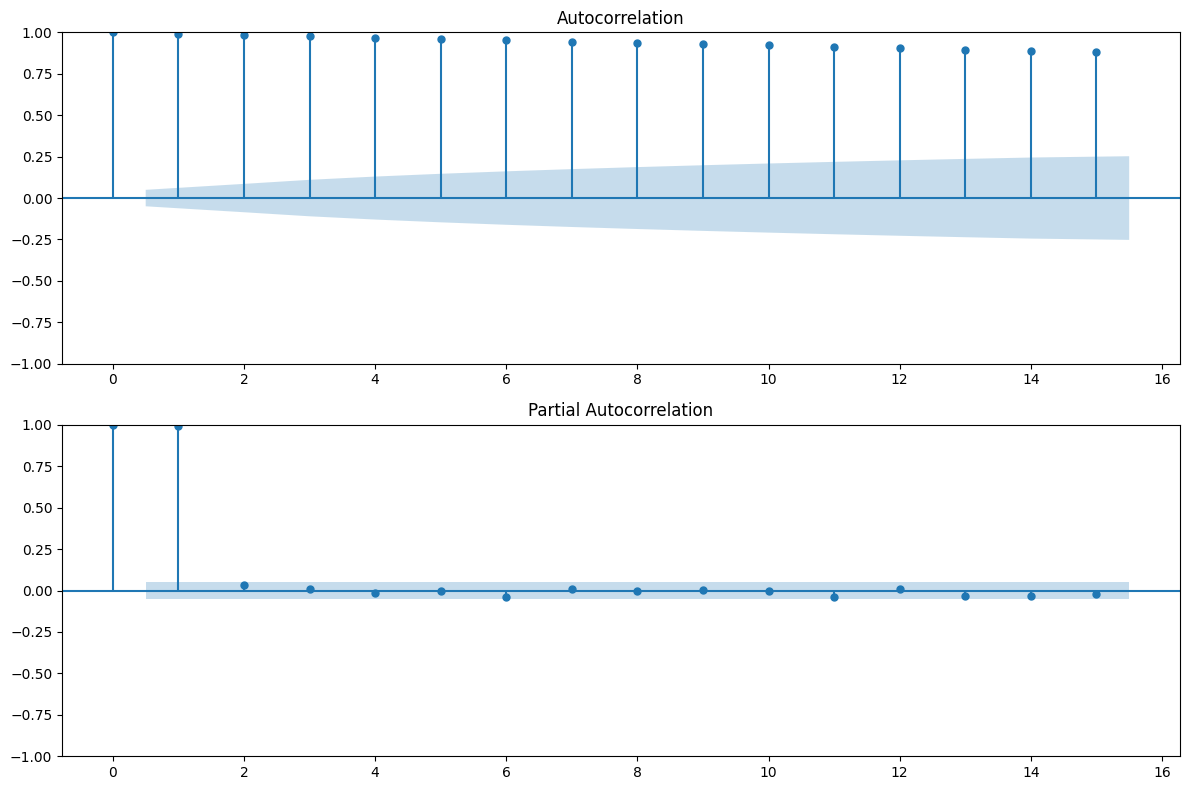

In [22]:
# Vẽ biểu đồ ACF và PACF để tìm q và p cho mô hình ARIMA
acf_pacf(dataBIDV)

C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given

RMSE: 9678.420181796702
MAE: 8347.492471857951
MAPE: 18.688029715301514%


C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


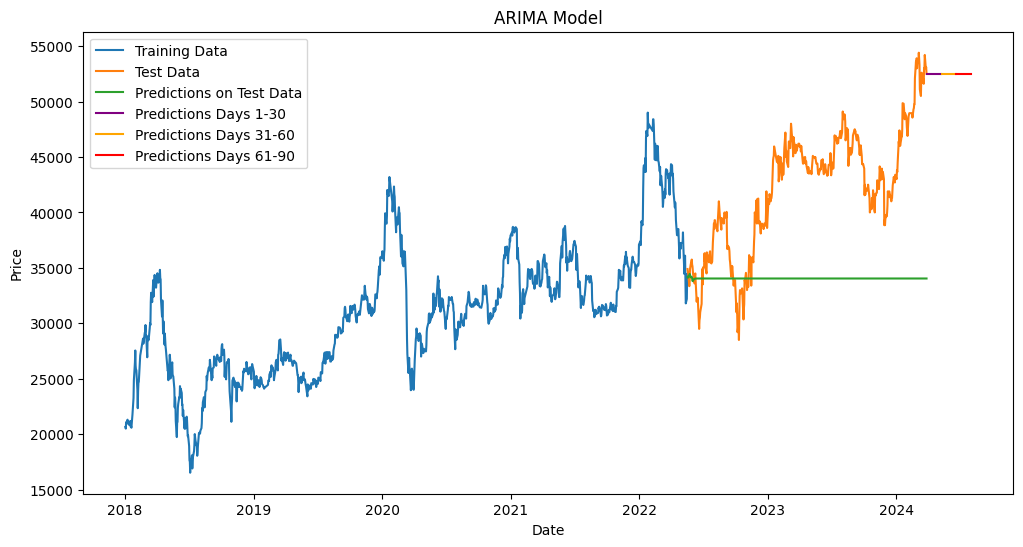

In [95]:
arima_model1(dataBIDV,1,1,15,0.7)

*train:test 8:2*

C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given

RMSE: 7109.504348599991
MAE: 6341.757683325533
MAPE: 13.607504105532032%


C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


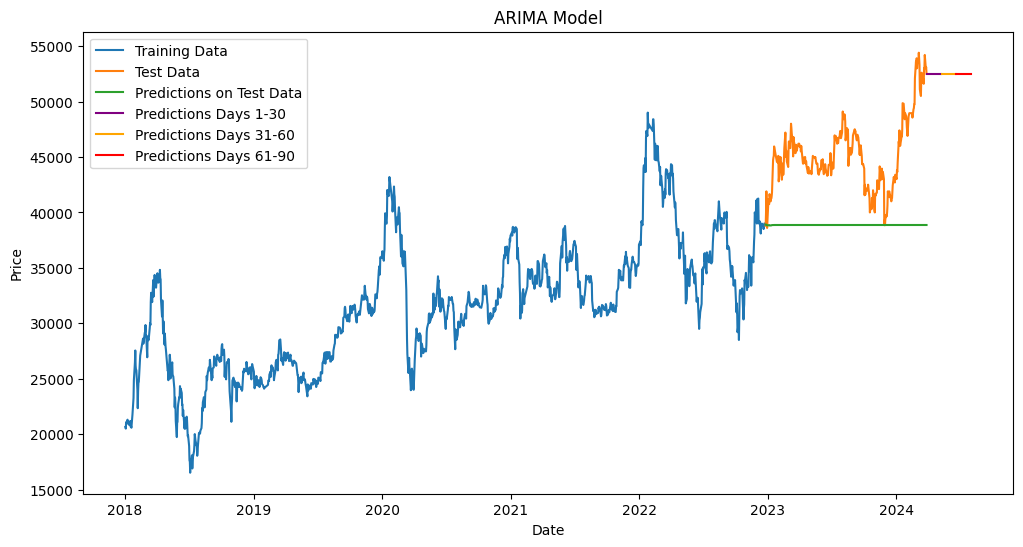

In [96]:
arima_model1(dataBIDV,1,1,15,0.8)

*train:test 9:1*

C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given

RMSE: 4192.145605298241
MAE: 3547.9701238037997
MAPE: 7.89039439153653%


C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


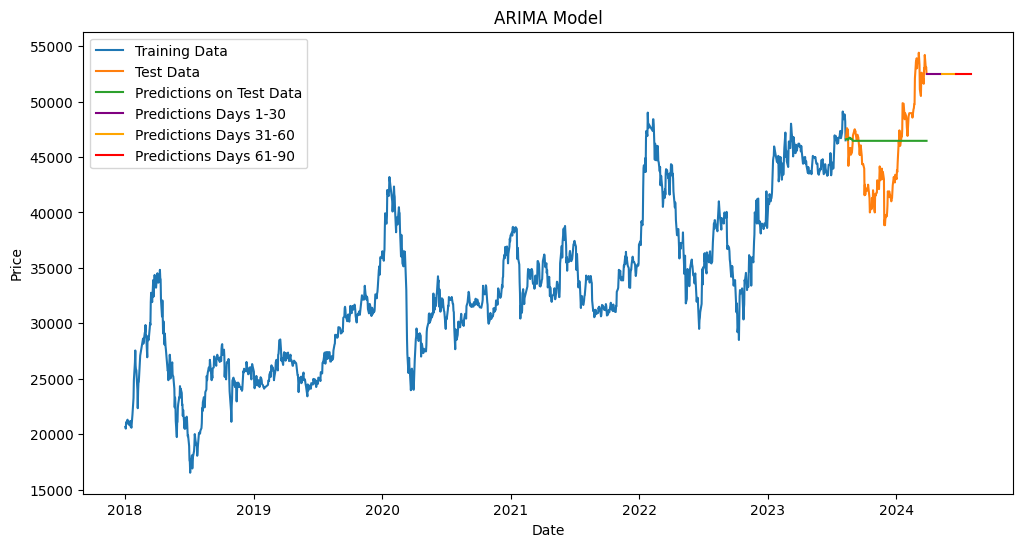

In [98]:
arima_model1(dataBIDV,1,1,15,0.9)

IMPLEMENT ARIMA WITH MBB DATA

In [100]:
dataMBB = import_data('../Dataset/MBB Historical Data.csv')

In [101]:
# Kiểm đinh tính dừng
i_data = integrate_series(dataMBB,1) # thay đổi tham số phía sau để kiểm tra tích hợp sai phân bậc mấy thì dữ liệu có tính dừng
check_stationarity(i_data)

ADF Statistic: -39.302588
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
Stationary


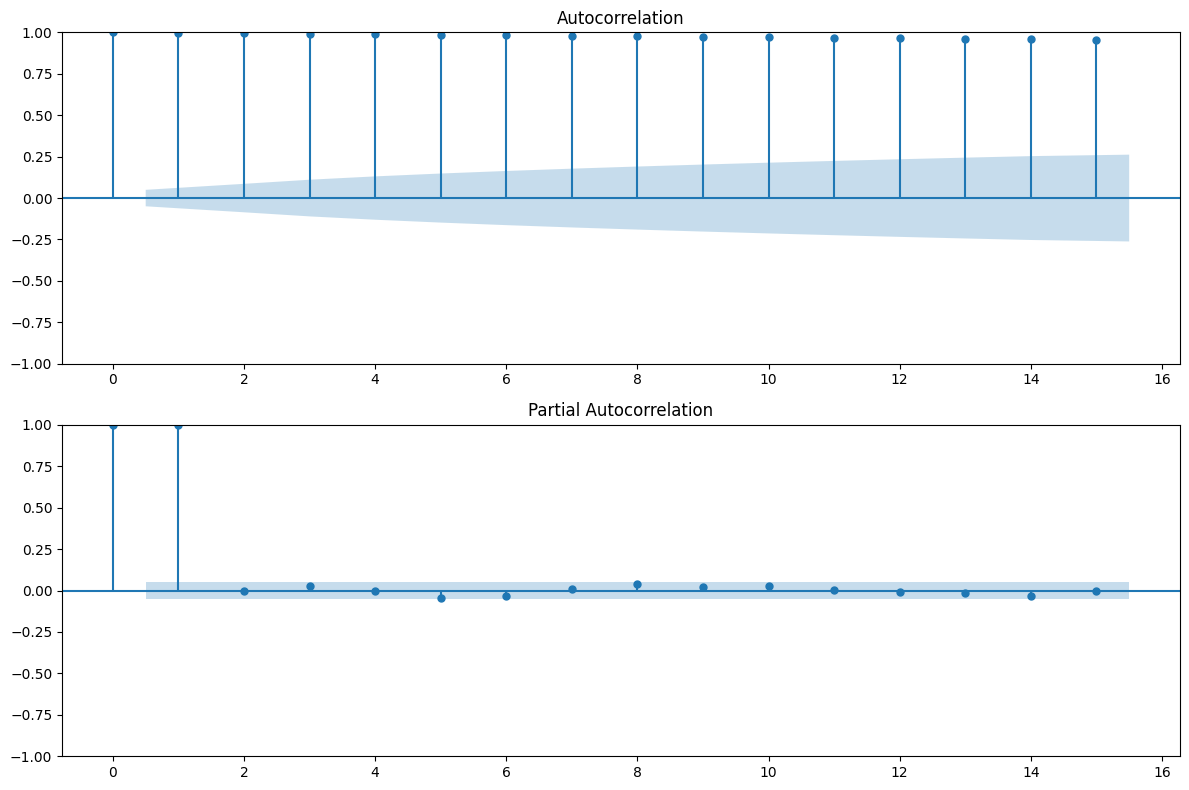

In [102]:
# Vẽ biểu đồ ACF và PACF để tìm q và p cho mô hình ARIMA
acf_pacf(dataMBB)

train:test 7:3

C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given

RMSE: 2958.6456812939523
MAE: 2641.5581193190355
MAPE: 14.258055249744542%


C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


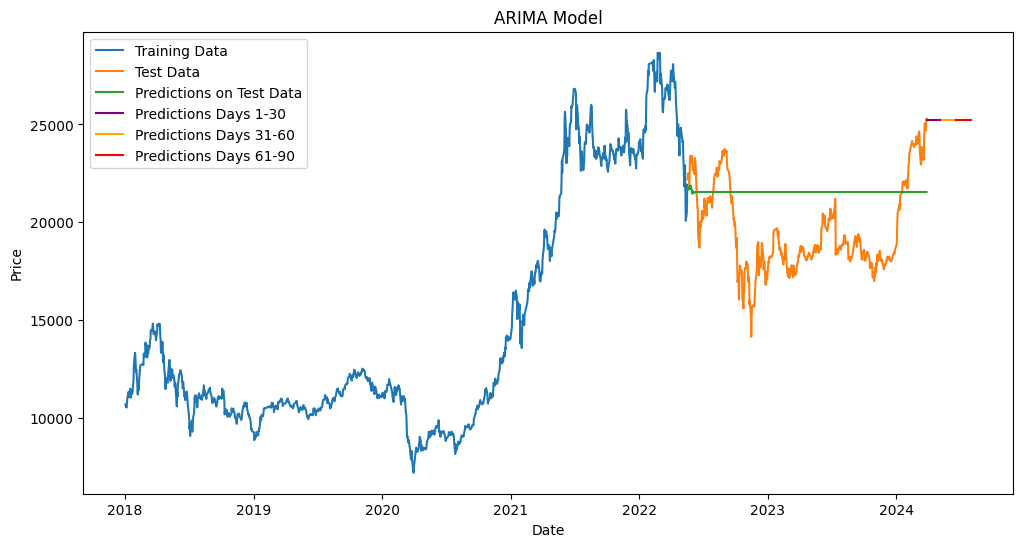

In [103]:
arima_model1(dataMBB,1,1,15,0.7)

train:test 8:2

C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given

RMSE: 2476.036085505013
MAE: 1614.404904562116
MAPE: 7.586224703365621%


C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


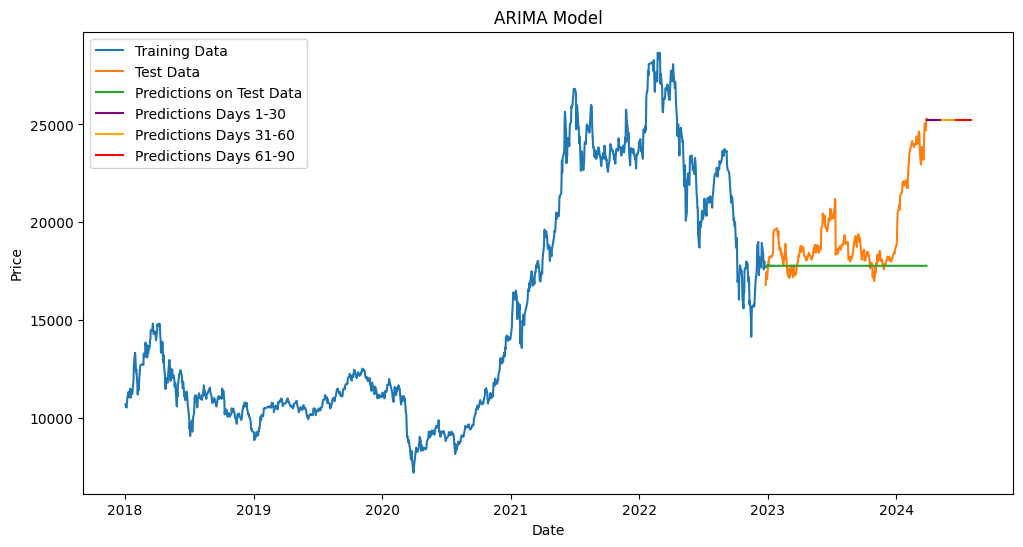

In [104]:
arima_model1(dataMBB,1,1,15,0.8)

train:test 9:1

C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given

RMSE: 2647.877023898095
MAE: 1890.6122373590847
MAPE: 8.649894803821972%


C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


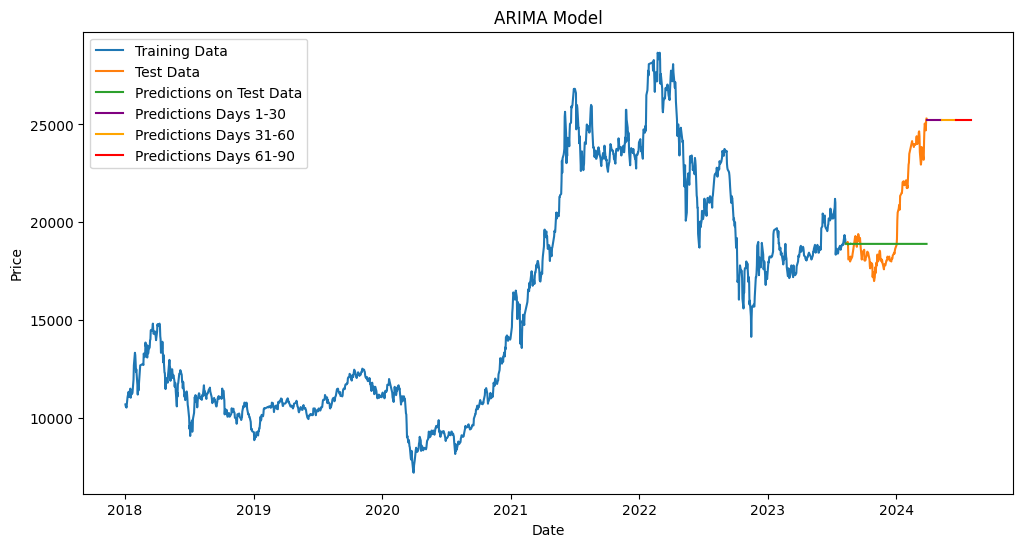

In [105]:
arima_model1(dataMBB,1,1,15,0.9)

IMPLEMENT ARIMA WITH VCB DATA

In [106]:
dataVCB = import_data('../Dataset/VCB Historical Data.csv')

In [ ]:
# Kiểm đinh tính dừng
i_data = integrate_series(dataVCB,1) # thay đổi tham số phía sau để kiểm tra tích hợp sai phân bậc mấy thì dữ liệu có tính dừng
check_stationarity(i_data)

ADF Statistic: -24.439638
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
Stationary


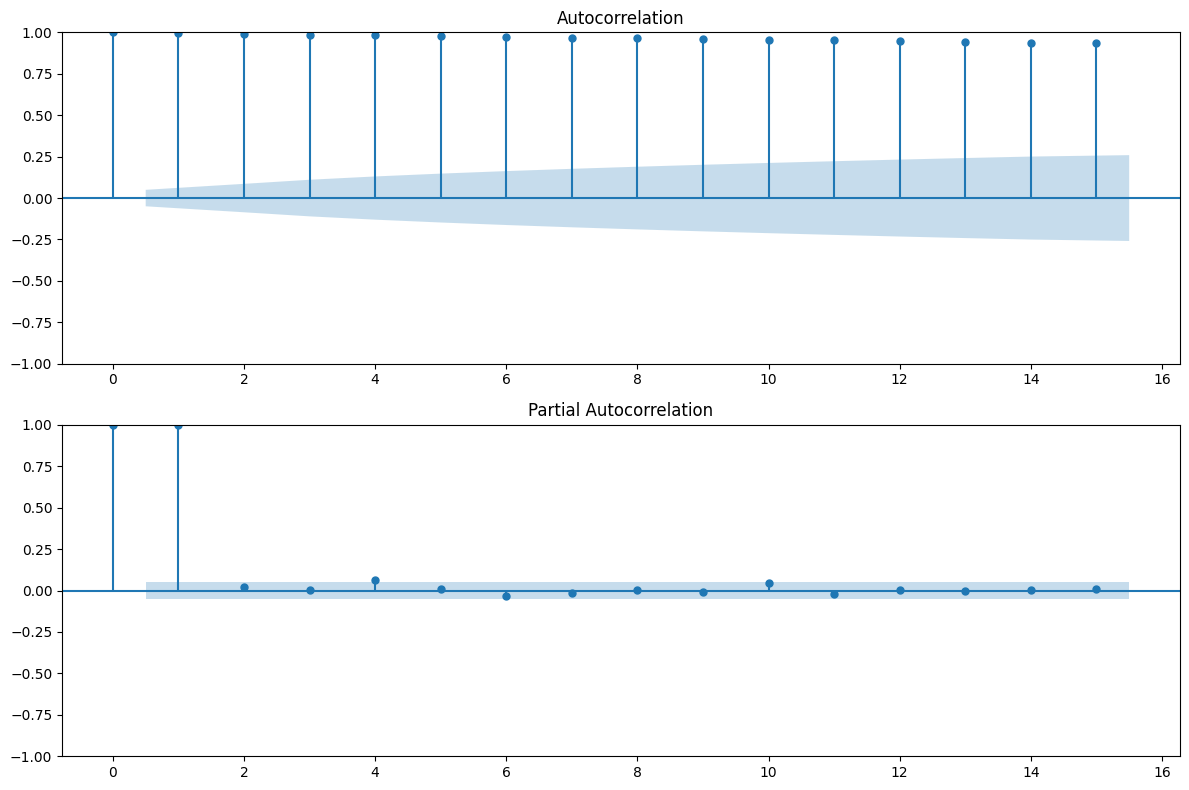

In [ ]:
# Vẽ biểu đồ ACF và PACF để tìm q và p cho mô hình ARIMA
acf_pacf(dataVCB)

train:test 7:3

C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given

RMSE: 13425.949926630256
MAE: 11325.760751996919
MAPE: 12.562594165188196%


C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


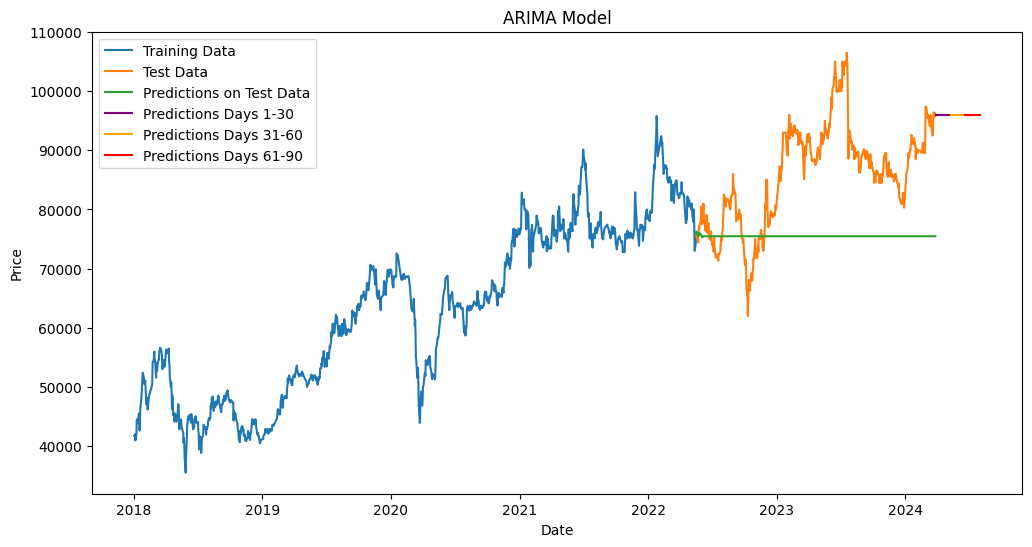

In [107]:
arima_model1(dataVCB,1,1,15,0.7)

train:test 8:2

C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given

RMSE: 13349.470825317014
MAE: 12204.32083865176
MAPE: 13.159225171828638%


C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


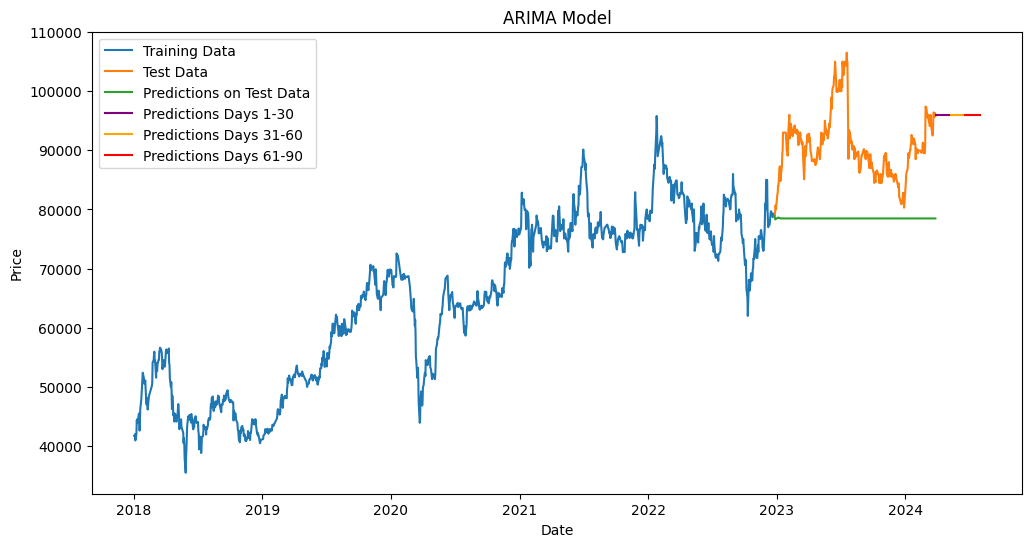

In [108]:
arima_model1(dataVCB,1,1,15,0.8)

train:test 9:1

C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given

RMSE: 3863.947557401782
MAE: 3021.4762054338125
MAPE: 3.3743019165516857%


C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\HUYPND\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


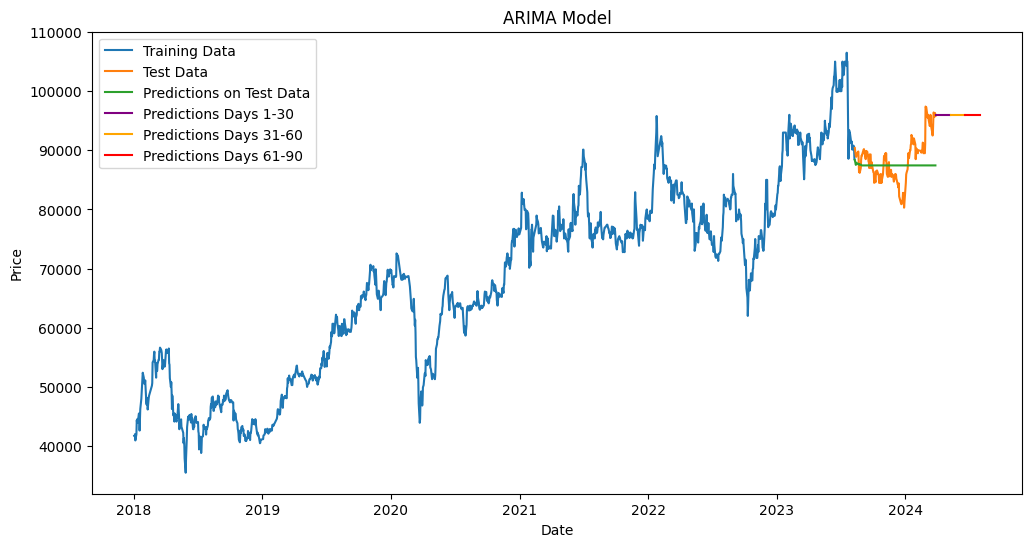

In [109]:
arima_model1(dataVCB,1,1,15,0.9)